In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights

# utils specific to quantization
from utils import train, quantize, initial_scales
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_resnet import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

# load pretrained model, accuracy ~81%
#model.load_state_dict(torch.load('../resnet/resnet18.pytorch_state'))

#### Keep copy of full precision kernels

In [9]:
# copy all full precision kernels of the model
all_fp_kernels = [
    Variable(kernel.data.clone(), requires_grad=True) 
    for kernel in optimizer.param_groups[2]['params']
]
# all_fp_kernels - kernel tensors of all convolutional layers 
# (with the exception of the first conv layer)

#### initial quantization 

In [10]:
# scaling factors for each quantized layer
initial_scaling_factors = []

In [11]:
# these kernels will be quantized
all_kernels = [kernel for kernel in optimizer.param_groups[2]['params']]

In [12]:
for k, k_fp in zip(all_kernels, all_fp_kernels):

    # choose initial scaling factors 
    w_p_initial, w_n_initial = initial_scales(k_fp.data)
    initial_scaling_factors += [(w_p_initial, w_n_initial)]

    # do quantization, this uses hyperparameter t defined in utils.py file
    k.data = quantize(k_fp.data, w_p_initial, w_n_initial)

#### parameter updaters

In [13]:
# optimizer for updating only all_fp_kernels
optimizer_fp = optim.SGD(all_fp_kernels, lr=1e-3, momentum=0.9, nesterov=True)

In [14]:
# optimizer for updating only scaling factors
optimizer_sf = optim.SGD([
    Variable(torch.FloatTensor([w_p, w_n]).cuda(), requires_grad=True) 
    for w_p, w_n in initial_scaling_factors
], lr=1e-3, momentum=0.9, nesterov=True)

# Train

In [15]:
n_epochs = 24
n_batches = ceil(train_size/batch_size)
n_batches

531

In [16]:
%%time
all_losses, _ = train(
    model, criterion, 
    optimizer, optimizer_fp, optimizer_sf,
    train_iterator, n_epochs, n_batches,
    val_iterator, validation_step=531, n_validation_batches=80
)
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)

1.00  5.503 5.643  0.011 0.010  0.044 0.062  113.576
2.00  5.163 5.065  0.045 0.047  0.143 0.139  112.828
3.00  4.749 4.540  0.097 0.101  0.257 0.256  112.800
4.00  4.397 4.223  0.151 0.141  0.346 0.319  112.467
5.00  4.125 3.901  0.197 0.185  0.407 0.400  112.809
6.00  3.884 3.592  0.229 0.227  0.457 0.479  112.476
7.00  3.691 3.384  0.259 0.276  0.497 0.524  112.664
8.00  3.525 3.172  0.283 0.315  0.529 0.573  112.676
9.00  3.366 3.025  0.307 0.338  0.559 0.602  112.862
10.00  3.256 2.890  0.318 0.363  0.574 0.636  112.146
11.00  3.165 2.831  0.336 0.374  0.592 0.647  112.742
12.00  3.068 2.726  0.351 0.397  0.610 0.665  113.384
13.00  2.980 2.658  0.360 0.402  0.630 0.672  112.595
14.00  2.906 2.580  0.376 0.420  0.639 0.697  112.357
15.00  2.850 2.572  0.387 0.419  0.646 0.687  112.324
16.00  2.778 2.449  0.393 0.447  0.659 0.719  112.959
17.00  2.728 2.353  0.403 0.465  0.664 0.729  112.466
18.00  2.673 2.289  0.414 0.475  0.682 0.746  112.594
19.00  2.623 2.232  0.421 0.488  0.68

# Loss/epoch plots

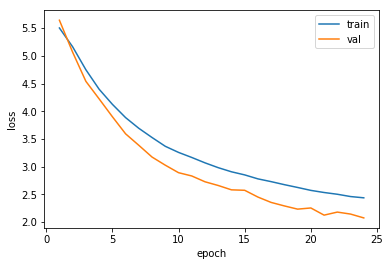

In [17]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

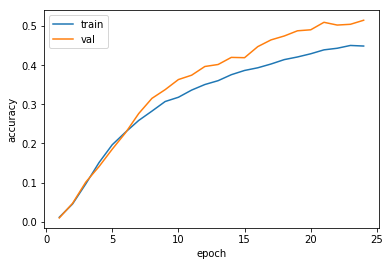

In [18]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

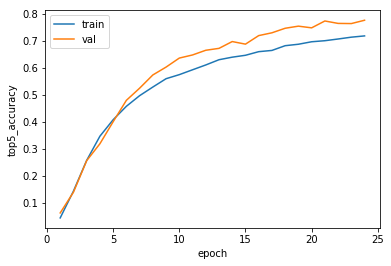

In [19]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [20]:
model.cpu();
torch.save(model.state_dict(), 'model_ternary_quantization.pytorch_state')